
# Customer Support LLM Dataset Pipeline (E2E)

**기능**: HF 데이터셋 3종 로드 → 스키마 통일 → 통합 → 중복 제거(정확/정규화/시맨틱) → 고객지원 도메인 품질 필터 → 분석/시각화 → 저장

**요구**: Python 3.9+, `datasets`, `pandas`, `numpy`, `scikit-learn`, `sentence-transformers`, `matplotlib`  
**선택**: `faiss`(옵션) — 미설치 시 `NearestNeighbors`로 대체


In [3]:

# ---- (필요시) 의존성 설치 ----
!pip -q install -U hf_transfer datasets pandas numpy scikit-learn sentence-transformers matplotlib

!pip -q install faiss-cpu


In [1]:

import os
import re
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ------------------------------
# 0. 설정(샘플링/유사도 임계값 등)
# ------------------------------
RANDOM_SEED = 42
MAX_SAMPLES_PER_DATASET = 5000      # 너무 크면 먼저 샘플링해서 파이프라인 속도 확보 시 임계값 (0~1)
SIMILARITY_THRESHOLD = 0.90         # 시맨틱 유사도(코사인) 임계값 (0~1)
PLOT_FIGURES = True                 # 시각화 실행 여부

np.random.seed(RANDOM_SEED)


In [2]:

# --------------------------------
# 1. 데이터 로드 (2개 데이터셋)
# --------------------------------
print("📥 Loading datasets from Hugging Face...\n")

# 1) 합성 CS 대화
ds1 = load_dataset("sutro/synthetic-customer-support-dialogues-20k")
# 2) 전형 CS 훈련셋(합성/템플릿 많음)
ds2 = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")


📥 Loading datasets from Hugging Face...



README.md:   0%|          | 0.00/100 [00:00<?, ?B/s]

20k-customer-support-dialogues-with-feat(…):   0%|          | 0.00/109M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

In [3]:
print(ds1)
print("---")
print(ds2)

DatasetDict({
    train: Dataset({
        features: ['product_name', 'product_description', 'customer_support_dialogue', 'issue_type', 'issue_severity', 'issue_description', 'resolution_path_description', 'outcome', 'customer_sentiment', 'customer_satisfaction', 'new_customer_support_dialogue', 'similarity_results', 'old_pii_results', 'new_pii_results'],
        num_rows: 20000
    })
})
---
DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})


In [4]:

# ----------------------------
# 2. 공통 포맷으로 통일 (unify)
# ----------------------------
# 목표 스키마: instruction | input | output | source
def unify(ds_split, cols_map, source_name, sample_cap=MAX_SAMPLES_PER_DATASET):
    """HF Dataset split을 pandas DF로 변환하고, 컬럼명을 instruction/input/output으로 통일."""
    df = pd.DataFrame(ds_split)
    # 샘플링(선택)
    if sample_cap and len(df) > sample_cap:
        df = df.sample(sample_cap, random_state=RANDOM_SEED)

    # 존재하는 키만 매핑(안전)
    keep_map = {k: v for k, v in cols_map.items() if v in df.columns}
    df = df.rename(columns=keep_map)

    # 없는 표준 컬럼은 빈 문자열로 생성
    for col in ["instruction", "input", "output"]:
        if col not in keep_map.values() and col not in df.columns:
            df[col] = ""

    # 표준 컬럼만 유지
    df = df[["instruction", "input", "output"]].copy()
    df["source"] = source_name
    return df

print("🧱 Unifying schema...\n")

# ds1: 제품/이슈/해결경로 기반 (없으면 outcome으로 백업)
df1_raw = pd.DataFrame(ds1["train"])
df1 = pd.DataFrame({
    "instruction": df1_raw.get("issue_description", "").astype(str).str.strip(),
    "input":       df1_raw.get("product_description", "").astype(str).str.strip(),
    "output":      np.where(
        df1_raw.get("resolution_path_description").notna(),
        df1_raw.get("resolution_path_description").astype(str).str.strip(),
        df1_raw.get("outcome", "").astype(str).str.strip()
    )
})
df1["source"] = "ds1_issue_product"

# ds2: 이미 instruction/response 존재, input 없음
df2 = unify(
    ds2["train"],
    {"instruction": "instruction", "output": "response"},  # input은 빈 칼럼로 남김
    "ds2_instruction_response"
)

# (선택) output 비거나 너무 짧은 샘플 제거
MIN_OUT_LEN = 5
df1 = df1[df1["output"].str.len() >= MIN_OUT_LEN].reset_index(drop=True)
df2 = df2[df2["output"].str.len() >= MIN_OUT_LEN].reset_index(drop=True)

# 통합
df_all = pd.concat([df1, df2], ignore_index=True)
print("통합 데이터셋 크기:", df_all.shape)
print(df_all.head(3).to_string(index=False))




🧱 Unifying schema...

통합 데이터셋 크기: (19959, 4)
                                                                                                                                                                                instruction                                                                                                                                               input                                                                                                                                                                                                                                                                            output            source
                                                          The customer wants to customize the message options on the Empower Poster kits with phrases tailored towards blue-collar workers. PERFECT GIFT FOR AGES 8 AND ABOVE: Make this feel-good poster by choosing the empowering words that describe why you're wonderful and truly

In [7]:

# -----------------------------------
# 3. 통합 & 기본 품질 (결측/공백 처리)
# -----------------------------------
df_all = pd.concat([df1, df2], ignore_index=True)
print(f"🔗 Merged dataset size: {df_all.shape}")

def clean_text(s):
    if pd.isna(s):
        return ""
    s = str(s)
    # 제어문자/연속공백 정리
    s = re.sub(r"[\u200b-\u200f\u202a-\u202e]", "", s)  # zero-width 등 제거(선택)
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

for col in ["instruction", "input", "output"]:
    df_all[col] = df_all[col].apply(clean_text)

# 완전 빈 샘플 제거
df_all = df_all[(df_all["instruction"] != "") | (df_all["input"] != "") | (df_all["output"] != "")]
df_all = df_all.reset_index(drop=True)

print(f"🧼 After basic cleaning: {df_all.shape}\n")


🔗 Merged dataset size: (19959, 4)
🧼 After basic cleaning: (19959, 4)



In [8]:

# --------------------------------------------------------
# 4. 중복 제거 단계 (Exact → Normalized → Semantic)
# --------------------------------------------------------
def concat_row(row):
    return f"{row['instruction']} | {row['input']} | {row['output']}"

df_all["blob"] = df_all.apply(concat_row, axis=1)

# 4-1) Exact Match
before = len(df_all)
df_exact = df_all.drop_duplicates(subset=["blob"]).copy()
print(f"🧩 Exact match: {before} → {len(df_exact)} (removed {before - len(df_exact)})")

# 4-2) Normalized Match
def normalize_blob(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9가-힣\s\.,\?!\-_/]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_exact["blob_norm"] = df_exact["blob"].apply(normalize_blob)
before = len(df_exact)
df_norm = df_exact.drop_duplicates(subset=["blob_norm"]).copy()
print(f"🧩 Normalized match: {before} → {len(df_norm)} (removed {before - len(df_norm)})")

dup_rows = df_all[df_all.duplicated(subset=["instruction"], keep=False)]
print("중복 instruction 수:", len(dup_rows))
dup_rows.head(5)


🧩 Exact match: 19959 → 19959 (removed 0)
🧩 Normalized match: 19959 → 19959 (removed 0)
중복 instruction 수: 201


,instruction,input,output,source,blob
100,The customer did not report any specific issue.,Part of the Brain Builder Series by FoxMind Ar...,None required; the conversation was a positive...,ds1_issue_product,The customer did not report any specific issue...
241,No issue reported; customer provided positive ...,APPLICATION - Perfect décor addition to any wa...,Agent acknowledged the feedback and offered on...,ds1_issue_product,No issue reported; customer provided positive ...
362,The customer did not report any specific issue...,Double-sided farm and pet shop Picture Panels ...,No resolution was needed as there was no repor...,ds1_issue_product,The customer did not report any specific issue...
403,No issue reported; the customer expressed sati...,Great Condition,The customer shared positive feedback and did ...,ds1_issue_product,No issue reported; the customer expressed sati...
406,The customer did not report any issues.,1 Kitty set,None required; the conversation was a positive...,ds1_issue_product,The customer did not report any issues. | 1 Ki...


In [9]:

# 4-3) Semantic Dedup (Sentence-BERT 임베딩 + 최근접 이웃)
from sentence_transformers import SentenceTransformer

print("\n🧠 Building semantic embeddings...")
embed_model = SentenceTransformer("all-MiniLM-L6-v2")  # 가볍고 빠른 모델
corpus = df_norm["blob"].tolist()
embeddings = embed_model.encode(corpus, batch_size=128, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

print("🔎 Nearest neighbor search (cosine)...")
# FAISS 사용 예시는 주석 처리 — 설치 시 주석 해제하여 사용 가능
try:
    import faiss
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings.astype(np.float32))
    D, I = index.search(embeddings.astype(np.float32), k=2)
    nn_sims = D[:, 1]
    nn_idx  = I[:, 1]
except Exception:
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto", metric="cosine")
    nbrs.fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings, n_neighbors=2)
    nn_sims = 1 - distances[:, 1]   # cosine similarity
    nn_idx  = indices[:, 1]

to_remove = set()
duplicate_pairs = []
for i, (sim, j) in enumerate(zip(nn_sims, nn_idx)):
    if i == j:
        continue
    if sim >= SIMILARITY_THRESHOLD:
        if j not in to_remove:
            to_remove.add(j)
            duplicate_pairs.append((i, j, float(sim)))

mask = np.ones(len(df_norm), dtype=bool)
mask[list(to_remove)] = False
df_semantic = df_norm[mask].copy().reset_index(drop=True)

print(f"🧩 Semantic dedup (cos sim≥{SIMILARITY_THRESHOLD}): {len(df_norm)} → {len(df_semantic)} (removed {len(df_norm)-len(df_semantic)})")



🧠 Building semantic embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

🔎 Nearest neighbor search (cosine)...
🧩 Semantic dedup (cos sim≥0.9): 19959 → 18569 (removed 1390)


In [10]:

# ------------------------------------------
# 5. 고객지원 도메인 품질 필터 (키워드/플레이스홀더/단답)
# ------------------------------------------
print("\n🔍 Customer Support domain quality filtering...")

support_keywords = [
    'help','issue','problem','order','account','refund','cancel','support','question',
    'how','what','why','when','where','can','could','unable','error','not working',
    "doesn't work",'customer','service','assistance','billing','payment','shipping'
]
def is_support_related(text):
    t = (text or "").lower()
    return any(k in t for k in support_keywords)

df_semantic["is_support"] = (df_semantic["instruction"].apply(is_support_related) |
                             df_semantic["output"].apply(is_support_related))
df_quality = df_semantic[df_semantic["is_support"]].copy()

# 플레이스홀더/템플릿 제거
placeholder_pattern = r'\[.*?\]|XXX|TODO|PLACEHOLDER|\{.*?\}|<.*?>'
df_quality = df_quality[~df_quality["output"].str.contains(placeholder_pattern, case=False, regex=True, na=False)]

# 너무 일반적인 단답 제거
generic_responses = ['ok','okay','sure','done','yes','no','thanks','thank you','welcome']
df_quality = df_quality[~df_quality["output"].str.lower().str.strip().isin(generic_responses)]

print(f"✅ Domain quality: {len(df_semantic)} → {len(df_quality)} (removed {len(df_semantic)-len(df_quality)})")



🔍 Customer Support domain quality filtering...
✅ Domain quality: 18569 → 18386 (removed 183)


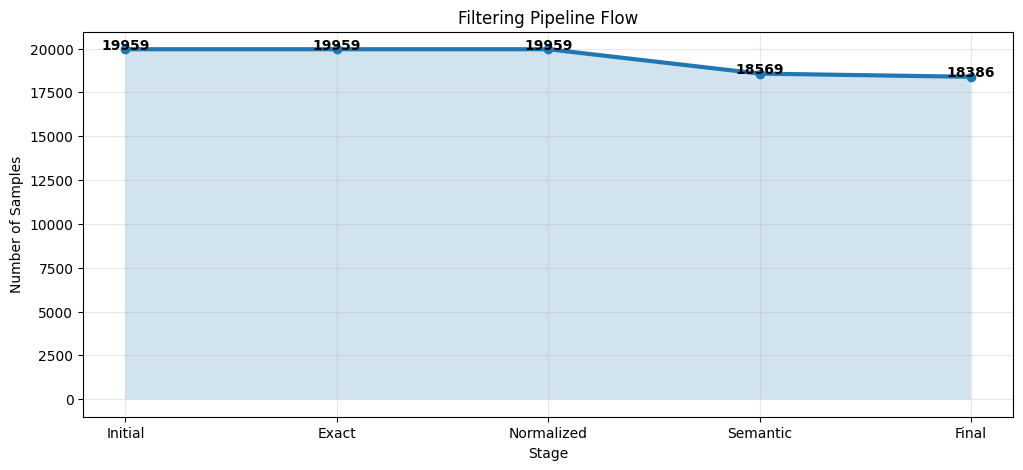

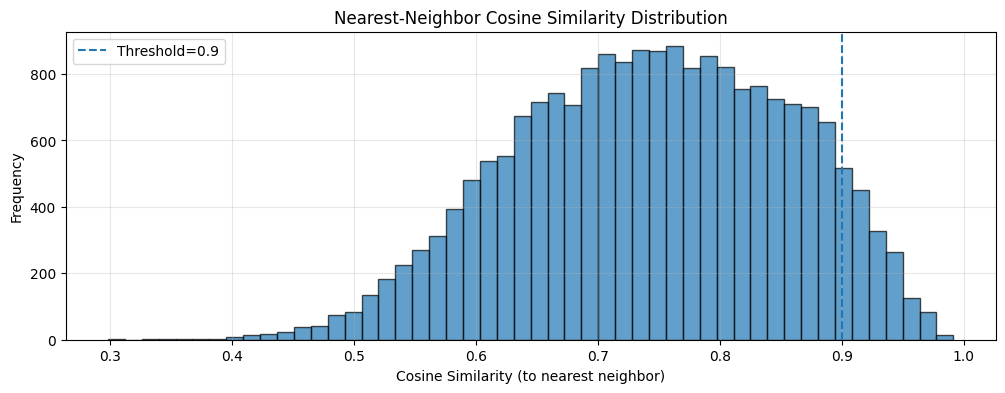

In [11]:

# --------------------------------
# 6. 분석/시각화 (선택)
# --------------------------------
if PLOT_FIGURES:
    stages = ["Initial", "Exact", "Normalized", "Semantic", "Final"]
    counts = [
        len(df_all),
        len(df_exact),
        len(df_norm),
        len(df_semantic),
        len(df_quality),
    ]

    plt.figure(figsize=(12,5))
    plt.plot(stages, counts, marker='o', linewidth=3)
    plt.fill_between(range(len(stages)), counts, alpha=0.2)
    for i,c in enumerate(counts):
        plt.text(i, c+3, str(c), ha='center', fontweight='bold')
    plt.title("Filtering Pipeline Flow")
    plt.xlabel("Stage")
    plt.ylabel("Number of Samples")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(12,4))
    plt.hist(nn_sims, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(SIMILARITY_THRESHOLD, linestyle='--', label=f"Threshold={SIMILARITY_THRESHOLD}")
    plt.title("Nearest-Neighbor Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity (to nearest neighbor)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [12]:
# --------------------------------
# 7. 요약 출력
# --------------------------------
print("\n📊 Summary")
print("----------")
print(f"Initial(all)     : {len(df_all)}")
print(f"After Exact      : {len(df_exact)}")
print(f"After Normalized : {len(df_norm)}")
print(f"After Semantic   : {len(df_semantic)}")
print(f"Final Quality    : {len(df_quality)}")

print("\n🔎 Sample rows:")
print(df_quality[["instruction","input","output","source"]].head(3).to_string(index=False))



📊 Summary
----------
Initial(all)     : 19959
After Exact      : 19959
After Normalized : 19959
After Semantic   : 18569
Final Quality    : 18386

🔎 Sample rows:
                                                                                                                                                                                instruction                                                                                                                                               input                                                                                                                                                                                                                                                                            output            source
                                                          The customer wants to customize the message options on the Empower Poster kits with phrases tailored towards blue-collar workers. PERFECT GIFT FOR AGES